In [1]:
from ESRNN.m4_data import *
from ESRNN.utils_evaluation import evaluate_prediction_owa
from ESRNN.utils_visualization import plot_grid_prediction

In [2]:
X_train_df, y_train_df, X_test_df, y_test_df = prepare_m4_data(dataset_name="Hourly",
                                                               directory="../data/M4",
                                                               num_obs=414)

In [3]:
prediction_length = 24*7

In [5]:
cuttoffs = y_train_df.groupby('unique_id')['ds'].transform(lambda x: x.max() - pd.Timedelta(hours=prediction_length))
training_data = y_train_df[y_train_df['ds'] <= cuttoffs]
test_data = y_train_df[y_train_df['ds'] > cuttoffs]


### ARIMA & Theta

In [40]:
from statsforecast import StatsForecast
from statsforecast.models import (
    AutoARIMA,
    HoltWinters,
    DynamicOptimizedTheta as DOT)


c:\Users\sonng\anaconda3\envs\tsff_env\lib\site-packages\statsforecast\core.py:25: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [41]:
models = [
    AutoARIMA(season_length=24),
    # HoltWinters(),
    DOT(season_length=24)]

In [42]:
sf = StatsForecast(
    df=training_data, 
    models=models,
    freq='H', 
    n_jobs=-1,
    fallback_model = AutoARIMA(season_length=24),
    verbose=True)


In [43]:
y_hat_df = sf.forecast(h=prediction_length)

y_hat_df.head()


,ds,AutoARIMA,DynamicOptimizedTheta
unique_id,,,
H1,1970-01-23 04:00:00,640.788025,638.218567
H1,1970-01-23 05:00:00,573.379028,572.250488
H1,1970-01-23 06:00:00,527.946167,524.863464
H1,1970-01-23 07:00:00,492.677826,490.736786
H1,1970-01-23 08:00:00,468.575775,468.916504


c:\Users\sonng\anaconda3\envs\tsff_env\lib\site-packages\statsforecast\core.py:1514: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["unique_id"] = df["unique_id"].astype(uid_dtype)


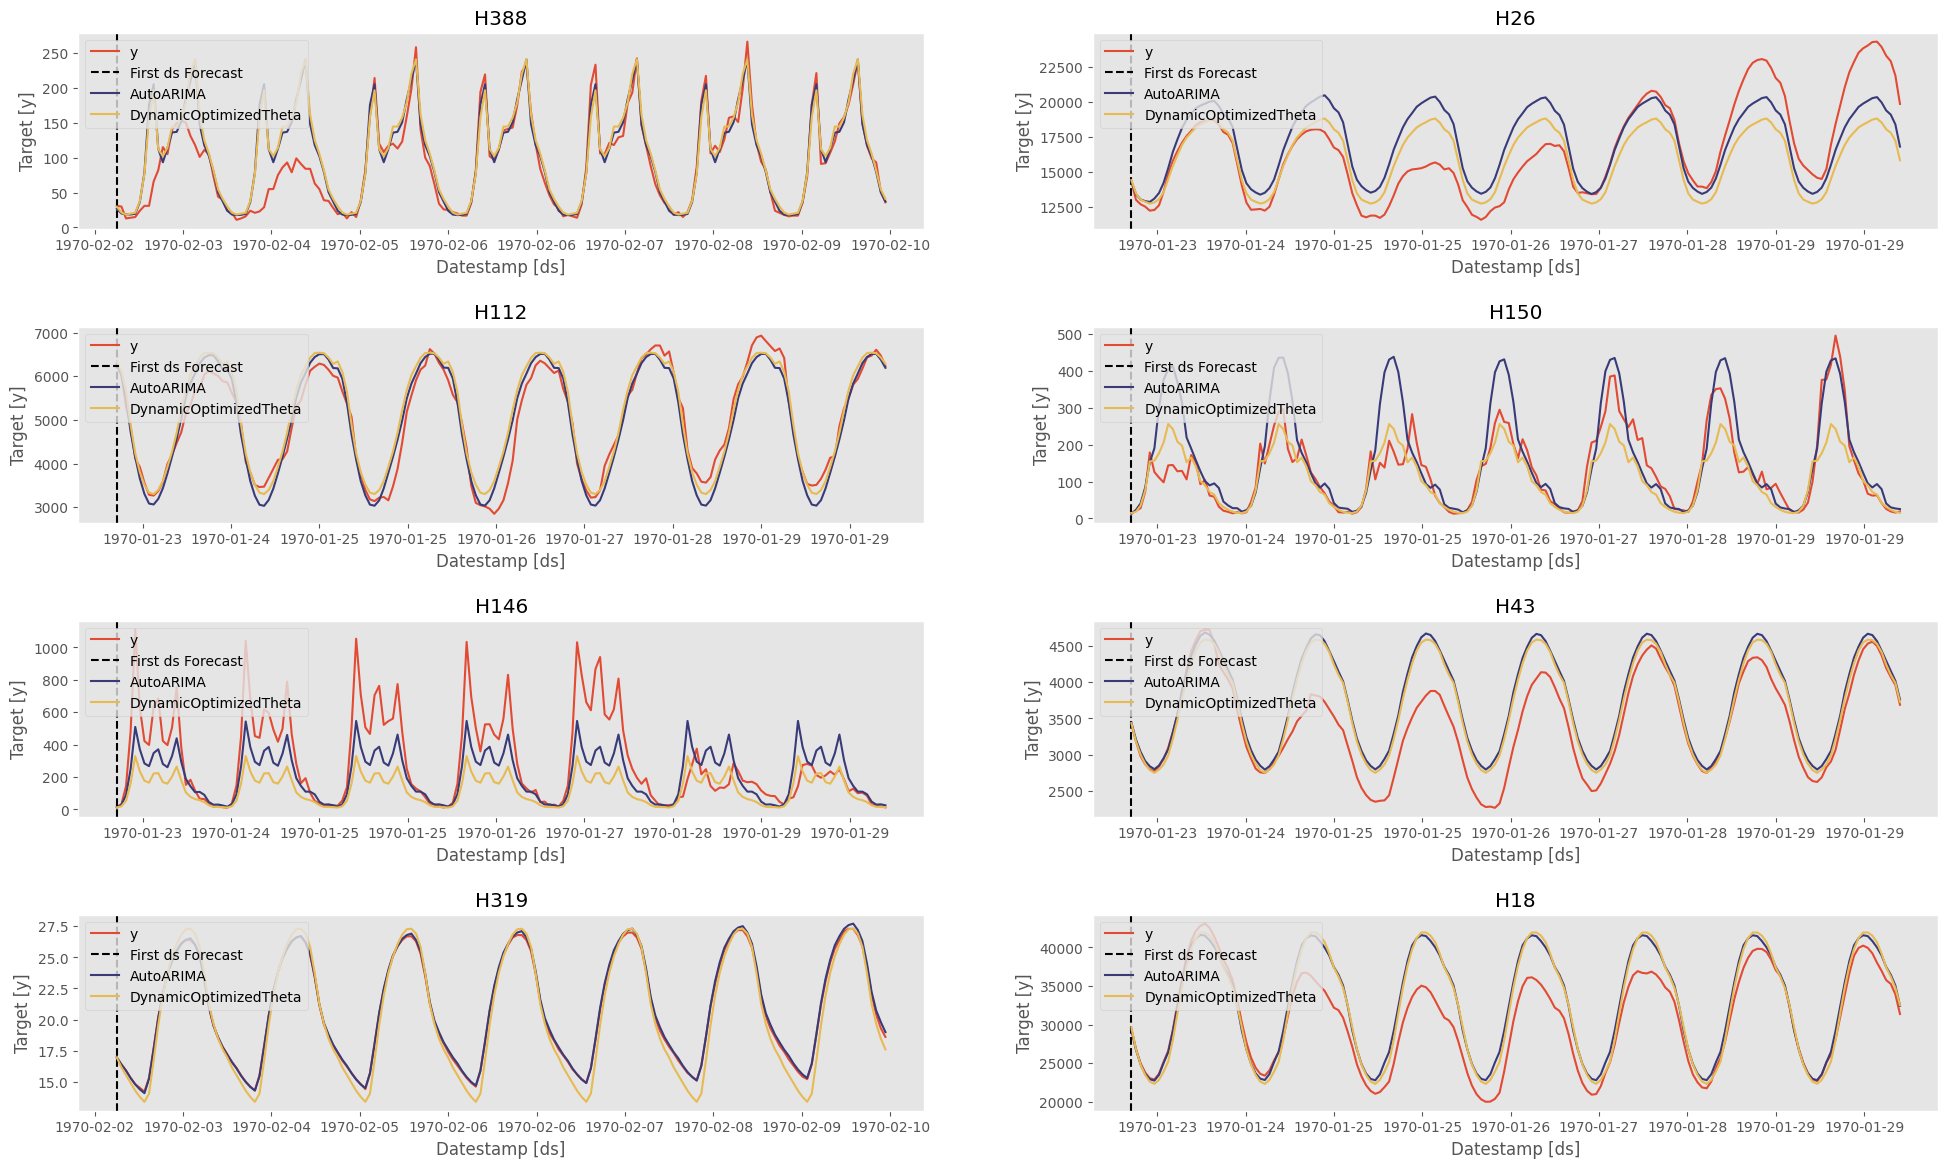

In [49]:
sf.plot(test_data, y_hat_df, engine='matplotlib')

In [46]:
y_hat_df_arima = y_hat_df.reset_index().iloc[:, [0, 1, 2]].rename(columns={'AutoARIMA' : 'y_hat'})
y_hat_df_theta = y_hat_df.reset_index().iloc[:, [0, 1, 3]].rename(columns={'DynamicOptimizedTheta' : 'y_hat'})

In [51]:
y_hat_df_arima.to_csv('../results/m4/base_model_train_set/y_hat_df_arima_ts.csv', index=False)
y_hat_df_theta.to_csv('../results/m4/base_model_train_set/y_hat_df_theta_ts.csv', index=False)

### XGBoost

In [17]:
prediction_length = 24*7

In [18]:
cuttoffs = y_train_df.groupby('unique_id')['ds'].transform(lambda x: x.max() - pd.Timedelta(hours=prediction_length))
training_data = y_train_df[y_train_df['ds'] <= cuttoffs]
test_data = y_train_df[y_train_df['ds'] > cuttoffs]


In [19]:
import numpy as np
import pandas as pd
import xgboost as xgb
from typing import Tuple
from sklearn.multioutput import MultiOutputRegressor

In [20]:
target_variable = 'y'
timestemp_col = 'ds'

hyperparameters = {
    "in_length": 7*24,             # Using 7 days (168 hours) of past observations
    "step_size": 24,               # Sliding the window by 24 steps each time
    "target_sequence_length": prediction_length, # Forecasting 24*7 hours ahead
    "n_estimators": 20,            # Number of gradient boosted trees
    "max_depth": 6,                # Maximum depth of a tree
    "subsample": 0.5,              # Fraction of samples to be used for fitting each tree
    "min_child_weight": 1,         # Minimum sum of instance weight (hessian) needed in a child
    "selected_features": [target_variable]  # Features selected for training the model
}

In [21]:
def get_indices_entire_sequence(data: pd.DataFrame, hyperparameters: dict) -> list:
    """
    Produce all the start and end index positions that are needed to produce
    the sub-sequences for the dataset.

    Args:
        data (pd.DataFrame): Partitioned data set, e.g., training data
        hyperparameters (dict): A dictionary containing the hyperparameters
        
    Return:
        indices: a list of tuples
    """

    window_size = hyperparameters['in_length'] + hyperparameters['target_sequence_length']
    step_size = hyperparameters['step_size']
    stop_position = len(data) - 1

    subseq_first_idx = 0
    subseq_last_idx = window_size

    indices = []

    while subseq_last_idx < stop_position:
        indices.append((subseq_first_idx, subseq_last_idx))
        subseq_first_idx += step_size
        subseq_last_idx += step_size

    return indices

In [22]:
def get_x_y(
        indices: list,
        data: pd.DataFrame,
        target_variable: str,
        target_sequence_length: int,
        input_seq_len: int
) -> Tuple[np.array, np.array]:
    
    print ("Preparing data...")
    """
    Obtaining the model inputs and targets (X,Y)
    """
    
    y_data = data[target_variable].values

    for i, idx in enumerate(indices):

        data_instance = y_data[idx[0]:idx[1]]

        x = data_instance[0: input_seq_len]
        y = data_instance[input_seq_len:input_seq_len + target_sequence_length]

        assert len(x) == input_seq_len
        assert len(y) == target_sequence_length

        if i == 0:
            X = x.reshape(1, -1)
            Y = y.reshape(1, -1)
        else:
            X = np.concatenate((X, x.reshape(1, -1)), axis=0)
            Y = np.concatenate((Y, y.reshape(1, -1)), axis=0)

    print ("Finished preparing data!")

    return X, Y

In [23]:
y_hat_df_xgb = pd.DataFrame()

for series_id in training_data['unique_id'].unique():

    print(f"Processing {series_id}...")

    series_train = training_data[training_data['unique_id'] == series_id]
    series_test = test_data[test_data['unique_id'] == series_id]

    training_indices = get_indices_entire_sequence(
        data=series_train,
        hyperparameters=hyperparameters)

    x_train, y_train = get_x_y(
        indices=training_indices, 
        data=series_train[hyperparameters["selected_features"]],
        target_variable=target_variable,
        target_sequence_length=hyperparameters["target_sequence_length"],
        input_seq_len=hyperparameters["in_length"]
    )

    x_test = series_train[hyperparameters["selected_features"]].iloc[-hyperparameters["in_length"]:].to_numpy().reshape(1, -1)

    model = xgb.XGBRegressor(
        n_estimators=hyperparameters["n_estimators"],
        max_depth=hyperparameters["max_depth"],
        subsample=hyperparameters["subsample"],
        min_child_weight=hyperparameters["min_child_weight"],
        objective="reg:squarederror",
        tree_method="hist"
    )

    trained_model = MultiOutputRegressor(model).fit(x_train, y_train)

    y_hat = trained_model.predict(x_test).reshape(-1, 1)

    series_predictions = pd.DataFrame({
    'unique_id': series_id,
    'ds': series_test['ds'].values,  
    'y': y_hat.squeeze()
    })

    y_hat_df_xgb = pd.concat([y_hat_df_xgb, series_predictions], axis=0)
    # print(y_hat_df_xgb)

    print(f"Finished {series_id}!") 



Processing H1...
Preparing data...
Finished preparing data!
Finished H1!
Processing H10...
Preparing data...
Finished preparing data!
Finished H10!
Processing H100...
Preparing data...
Finished preparing data!
Finished H100!
Processing H101...
Preparing data...
Finished preparing data!
Finished H101!
Processing H102...
Preparing data...
Finished preparing data!
Finished H102!
Processing H103...
Preparing data...
Finished preparing data!
Finished H103!
Processing H104...
Preparing data...
Finished preparing data!
Finished H104!
Processing H105...
Preparing data...
Finished preparing data!
Finished H105!
Processing H106...
Preparing data...
Finished preparing data!
Finished H106!
Processing H107...
Preparing data...
Finished preparing data!
Finished H107!
Processing H108...
Preparing data...
Finished preparing data!
Finished H108!
Processing H109...
Preparing data...
Finished preparing data!
Finished H109!
Processing H11...
Preparing data...
Finished preparing data!
Finished H11!
Process

In [24]:
y_hat_df_xgb

,unique_id,ds,y
0,H1,1970-01-23 04:00:00,797.352051
1,H1,1970-01-23 05:00:00,749.651306
2,H1,1970-01-23 06:00:00,743.404785
3,H1,1970-01-23 07:00:00,685.003723
4,H1,1970-01-23 08:00:00,622.734680
...,...,...,...
163,H99,1970-01-29 23:00:00,21028.179688
164,H99,1970-01-30 00:00:00,21035.613281
165,H99,1970-01-30 01:00:00,21088.265625
166,H99,1970-01-30 02:00:00,21595.632812


In [25]:
y_hat_df_xgb.to_csv('../results/m4/base_model_train_set/y_hat_df_xgb_ts.csv', index=False)


### GRU

In [26]:
X_train_df, y_train_df, X_test_df, y_test_df = prepare_m4_data(dataset_name="Hourly",
                                                               directory="../data/M4",
                                                               num_obs=414)

In [27]:
prediction_length = 24*7

In [28]:
cuttoffs = y_train_df.groupby('unique_id')['ds'].transform(lambda x: x.max() - pd.Timedelta(hours=prediction_length))
training_data = y_train_df[y_train_df['ds'] <= cuttoffs]
test_data = y_train_df[y_train_df['ds'] > cuttoffs]


In [29]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [30]:
seq_length = 24*7
target_seq_length = prediction_length
input_size = 1
hidden_size = 10
num_layers = 1
output_size = 1
learning_rate = 0.01
epochs = 1000
batch_n = 128

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
def normalize_data(data):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_data = scaler.fit_transform(data.reshape(-1, 1))
    scaled_data = scaled_data.flatten()

    return scaled_data, scaler
    

In [33]:
def create_sequence(df, unique_id, seq_length):
    # Xs, Ys = [], []
    sequence_dict = {}
    grouped = df.groupby(unique_id)

    for group_id, group in grouped:
        data = group['y'].values
        data, scaler = normalize_data(data)
        X, Y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:(i + seq_length)])
            Y.append(data[i + seq_length])
        sequence_dict[group_id] = {'X' : np.array(X), 'y': np.array(Y), 'scaler' : scaler}

    return sequence_dict

In [34]:
class GRU_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        gru_out, _ = self.gru(x, h0)
        out = self.fc(gru_out[:, -1, :])
        return out

In [35]:
def train_model(model,
                criterion,
                optimizer,
                X_train,
                y_train,
                target_seq_length = target_seq_length,
                batch_size = 64,
                epochs=100):
    
    dataset = TensorDataset(X_train, y_train)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):

        model.train()

        for batch_idx, (sequences, targets) in enumerate(data_loader):

            sequences, targets = sequences.to(device), targets.to(device)

            # put default model grads to zero
            optimizer.zero_grad()

            # predict the output
            pred = model(sequences)

            # calculate the loss
            loss = criterion(pred, targets)

            # backpropagate the error
            loss.backward()

            # update the model parameters
            optimizer.step()

        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}')

    # generating forecasts
    model.eval()
    last_sequence = X_train[-1:].to(device)
    forecast_seq = torch.Tensor().to(device)

    for _ in range(target_seq_length):
        with torch.no_grad():
            
            next_step_forecast = model(last_sequence)

            forecast_seq = torch.cat((forecast_seq, next_step_forecast[:, -1:]), dim=1)

            last_sequence = torch.cat((last_sequence[:, 1:, :], next_step_forecast[:, -1:].unsqueeze(-1)), dim=1)
    
    return model, forecast_seq

In [36]:
sequences_dict = create_sequence(training_data, 'unique_id', seq_length)

In [41]:
y_hat_df_gru = test_data.copy().rename(columns={'y' : 'y_hat'})
y_hat_df_gru['y_hat'] = pd.Series(dtype='float64')

all_forecast_seq_descaled = []

for series_id in sequences_dict.keys():

    print(f'Series {series_id}')
    
    X_train = torch.from_numpy(sequences_dict[series_id]['X'].astype(np.float32)).unsqueeze(-1)
    y_train = torch.from_numpy(sequences_dict[series_id]['y'].astype(np.float32)).unsqueeze(-1)

    model = GRU_Model(input_size, hidden_size, num_layers, output_size)
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model_gru, forecast_seq = train_model(model,
                                          criterion=criterion,
                                          optimizer=optimizer,
                                          X_train=X_train,
                                          y_train=y_train,
                                          batch_size=batch_n,
                                          epochs=epochs)
    
    forecast_seq_descaled = sequences_dict[series_id]['scaler'].inverse_transform(forecast_seq.cpu().numpy()).flatten()
    # all_forecast_seq_descaled = np.hstack(all_forecast_seq_descaled, forecast_seq_descaled)
    all_forecast_seq_descaled.append(forecast_seq_descaled)

all_forecast_seq_descaled = np.hstack(all_forecast_seq_descaled)

y_hat_df_gru['y_hat'] = all_forecast_seq_descaled


Series H1
Epoch [100/1000], Loss: 0.0025253030471503735
Epoch [200/1000], Loss: 0.0022268351167440414
Epoch [300/1000], Loss: 0.002103495644405484
Epoch [400/1000], Loss: 0.0019405712373554707
Epoch [500/1000], Loss: 0.0017364397644996643
Epoch [600/1000], Loss: 0.00110698863863945
Epoch [700/1000], Loss: 0.001160884159617126
Epoch [800/1000], Loss: 0.0007340336451306939
Epoch [900/1000], Loss: 0.0006829591584391892
Epoch [1000/1000], Loss: 0.0006652489537373185
Series H10
Epoch [100/1000], Loss: 0.01423668209463358
Epoch [200/1000], Loss: 0.012675799429416656
Epoch [300/1000], Loss: 0.010407530702650547
Epoch [400/1000], Loss: 0.011899130418896675
Epoch [500/1000], Loss: 0.010021401569247246
Epoch [600/1000], Loss: 0.009432959370315075
Epoch [700/1000], Loss: 0.008862567134201527
Epoch [800/1000], Loss: 0.007286048494279385
Epoch [900/1000], Loss: 0.0063159046694636345
Epoch [1000/1000], Loss: 0.0061101350001990795
Series H100
Epoch [100/1000], Loss: 0.018317002803087234
Epoch [200/10

In [52]:
y_hat_df_gru.drop(columns=['index'], inplace=True)

In [53]:
y_hat_df_gru

,unique_id,ds,y_hat
0,H1,1970-01-23 04:00:00,703.123535
1,H1,1970-01-23 05:00:00,635.246338
2,H1,1970-01-23 06:00:00,573.028076
3,H1,1970-01-23 07:00:00,525.734802
4,H1,1970-01-23 08:00:00,493.566071
...,...,...,...
69547,H99,1970-01-29 23:00:00,20118.818359
69548,H99,1970-01-30 00:00:00,18960.708984
69549,H99,1970-01-30 01:00:00,17356.619141
69550,H99,1970-01-30 02:00:00,15822.047852


In [54]:
y_hat_df_gru.to_csv('../results/m4/base_model_train_set/y_hat_df_gru_ts.csv', index=False)


### LSTM

In [55]:
prediction_length = 24*7

In [56]:
cuttoffs = y_train_df.groupby('unique_id')['ds'].transform(lambda x: x.max() - pd.Timedelta(hours=prediction_length))
training_data = y_train_df[y_train_df['ds'] <= cuttoffs]
test_data = y_train_df[y_train_df['ds'] > cuttoffs]


In [57]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [66]:
seq_length = 24*7
target_seq_length = prediction_length
input_size = 1
hidden_size = 10
num_layers = 1
output_size = 1
learning_rate = 0.005
epochs = 1500
batch_n = 128

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [68]:
def normalize_data(data):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_data = scaler.fit_transform(data.reshape(-1, 1))
    scaled_data = scaled_data.flatten()

    return scaled_data, scaler
    

In [69]:
def create_sequence(df, unique_id, seq_length):
    # Xs, Ys = [], []
    sequence_dict = {}
    grouped = df.groupby(unique_id)

    for group_id, group in grouped:
        data = group['y'].values
        data, scaler = normalize_data(data)
        X, Y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:(i + seq_length)])
            Y.append(data[i + seq_length])
        sequence_dict[group_id] = {'X' : np.array(X), 'y': np.array(Y), 'scaler' : scaler}

    return sequence_dict

In [70]:
class LSTM_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        lstm_out, _ = self.lstm(x, (h0, c0))
        out = self.fc(lstm_out[:, -1, :])
        return out

In [71]:
def train_model(model,
                criterion,
                optimizer,
                X_train,
                y_train,
                target_seq_length = target_seq_length,
                batch_size = 64,
                epochs=100):
    
    dataset = TensorDataset(X_train, y_train)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):

        model.train()

        for batch_idx, (sequences, targets) in enumerate(data_loader):

            sequences, targets = sequences.to(device), targets.to(device)

            # put default model grads to zero
            optimizer.zero_grad()

            # predict the output
            pred = model(sequences)

            # calculate the loss
            loss = criterion(pred, targets)

            # backpropagate the error
            loss.backward()

            # update the model parameters
            optimizer.step()

        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}')

    # generating forecasts
    model.eval()
    last_sequence = X_train[-1:].to(device)
    forecast_seq = torch.Tensor().to(device)

    for _ in range(target_seq_length):
        with torch.no_grad():
            
            next_step_forecast = model(last_sequence)

            forecast_seq = torch.cat((forecast_seq, next_step_forecast[:, -1:]), dim=1)

            last_sequence = torch.cat((last_sequence[:, 1:, :], next_step_forecast[:, -1:].unsqueeze(-1)), dim=1)
    
    return model, forecast_seq

In [72]:
sequences_dict = create_sequence(training_data, 'unique_id', seq_length)

In [73]:
y_hat_df_lstm = test_data.copy().rename(columns={'y' : 'y_hat'})
y_hat_df_lstm['y_hat'] = pd.Series(dtype='float64')

all_forecast_seq_descaled = []

for series_id in sequences_dict.keys():

    print(f'Series {series_id}')
    
    X_train = torch.from_numpy(sequences_dict[series_id]['X'].astype(np.float32)).unsqueeze(-1)
    y_train = torch.from_numpy(sequences_dict[series_id]['y'].astype(np.float32)).unsqueeze(-1)

    model = LSTM_Model(input_size, hidden_size, num_layers, output_size)
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model_gru, forecast_seq = train_model(model,
                                          criterion=criterion,
                                          optimizer=optimizer,
                                          X_train=X_train,
                                          y_train=y_train,
                                          batch_size=batch_n,
                                          epochs=epochs)
    
    forecast_seq_descaled = sequences_dict[series_id]['scaler'].inverse_transform(forecast_seq.cpu().numpy()).flatten()
    # all_forecast_seq_descaled = np.hstack(all_forecast_seq_descaled, forecast_seq_descaled)
    all_forecast_seq_descaled.append(forecast_seq_descaled)

all_forecast_seq_descaled = np.hstack(all_forecast_seq_descaled)

y_hat_df_lstm['y_hat'] = all_forecast_seq_descaled


Series H1
Epoch [100/1500], Loss: 0.0038095545023679733
Epoch [200/1500], Loss: 0.0017805852694436908
Epoch [300/1500], Loss: 0.0013962609227746725
Epoch [400/1500], Loss: 0.0011861404636874795
Epoch [500/1500], Loss: 0.0009891102090477943
Epoch [600/1500], Loss: 0.0009509761002846062
Epoch [700/1500], Loss: 0.0008519953698851168
Epoch [800/1500], Loss: 0.0009179579210467637
Epoch [900/1500], Loss: 0.000960624311119318
Epoch [1000/1500], Loss: 0.0006810209597460926
Epoch [1100/1500], Loss: 0.0006522095645777881
Epoch [1200/1500], Loss: 0.0006310830358415842
Epoch [1300/1500], Loss: 0.0006587188108824193
Epoch [1400/1500], Loss: 0.000626436376478523
Epoch [1500/1500], Loss: 0.0006102007464505732
Series H10
Epoch [100/1500], Loss: 0.012178489938378334
Epoch [200/1500], Loss: 0.012231105007231236
Epoch [300/1500], Loss: 0.011205100454390049
Epoch [400/1500], Loss: 0.010180987417697906
Epoch [500/1500], Loss: 0.014880727976560593
Epoch [600/1500], Loss: 0.009085239842534065
Epoch [700/1500

In [75]:
y_hat_df_lstm.reset_index(drop=True, inplace=True)

In [76]:
y_hat_df_lstm

,unique_id,ds,y_hat
0,H1,1970-01-23 04:00:00,700.605347
1,H1,1970-01-23 05:00:00,634.413696
2,H1,1970-01-23 06:00:00,569.606689
3,H1,1970-01-23 07:00:00,524.299377
4,H1,1970-01-23 08:00:00,493.819275
...,...,...,...
69547,H99,1970-01-29 23:00:00,24763.273438
69548,H99,1970-01-30 00:00:00,24508.593750
69549,H99,1970-01-30 01:00:00,23856.597656
69550,H99,1970-01-30 02:00:00,23196.181641


In [77]:
y_hat_df_lstm.to_csv('../results/m4/base_model_train_set/y_hat_df_lstm_ts.csv', index=False)
